In [1]:
import pandas as pd
import matplotlib.pyplot as plt


# import constraint Learning Tool 
import sys
import os

sys.path.insert(0, os.path.join(os.getcwd(), 'DistCL_code_modified'))
from distcl import distcl
import torch
from src.visualize import plot_two_turbine_results

from sklearn.model_selection import train_test_split

import itertools
import numpy as np

from sklearn.metrics import mean_squared_error
import numpy as np


In [2]:
data = pd.read_csv("data/two_turbine_deterministic270.csv")
data.head()

,x_turb2,y_turb2,wind_speed,wind_direction,turbulence_intensity,turbine1_power,turbine2_powers,farm_power
0,0.0,0.0,8.0,270.0,0.06,1753.954459,1753.954459,3507.908918
1,0.0,50.0,8.0,270.0,0.06,1753.954459,1753.954459,3507.908918
2,0.0,100.0,8.0,270.0,0.06,1753.954459,1753.954459,3507.908918
3,0.0,150.0,8.0,270.0,0.06,1753.954459,1753.954459,3507.908918
4,0.0,200.0,8.0,270.0,0.06,1753.954459,1753.954459,3507.908918


In [3]:
### Test/Train Split
# Split the data into training, validation, and test sets
train_data, temp_data = train_test_split(data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

val_ind = val_data.index
test_ind = test_data.index


# Train the model with the current parameters
cl_tool = distcl(X=data[["x_turb2", "y_turb2", "wind_speed", "wind_direction", "turbulence_intensity"]],
                    y=data["farm_power"], n_preds=1, val_ind=val_ind, test_ind=test_ind)


# optimize NN

Training with n_hidden=1, n_nodes=5
DistFCNN(
  (lin_layers): ModuleList(
    (0): Linear(in_features=5, out_features=5, bias=True)
  )
  (output_mean_layer): Linear(in_features=5, out_features=1, bias=True)
  (droput_layers): ModuleList(
    (0): Dropout(p=0.05, inplace=False)
  )
)
cpu
epoch 0 loss 0.8581812381744385
epoch 500 loss 0.4235323667526245
epoch 1000 loss 0.2676551043987274
epoch 1500 loss 0.197370246052742
epoch 2000 loss 0.14997033774852753
epoch 2500 loss 0.11699853092432022
epoch 3000 loss 0.09341232478618622
epoch 3500 loss 0.074896901845932
epoch 4000 loss 0.06248895078897476
epoch 4500 loss 0.05345917120575905
NN fitting process finished with a validation MSE loss of 0.04851274564862251 in epoch 4999
Training with n_hidden=1, n_nodes=8
DistFCNN(
  (lin_layers): ModuleList(
    (0): Linear(in_features=5, out_features=8, bias=True)
  )
  (output_mean_layer): Linear(in_features=8, out_features=1, bias=True)
  (droput_layers): ModuleList(
    (0): Dropout(p=0.05, inplac

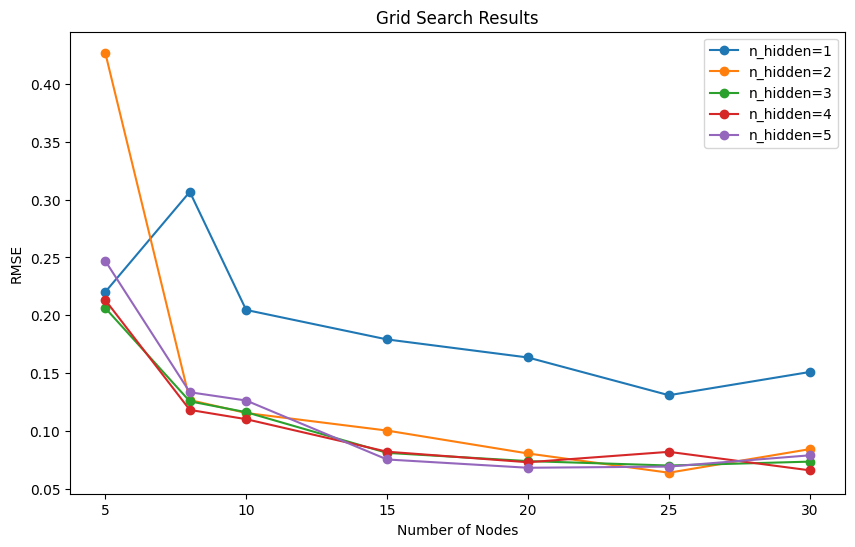

In [4]:
param_grid = {
    'n_hidden': [1, 2, 3, 4, 5],
    'n_nodes': [5, 8, 10, 15, 20, 25, 30]
}

best_params, best_rmse, grid_search = cl_tool.optimize_nn(param_grid = param_grid,iters = 5000,plot = True)

In [11]:
# Retrain the model with the best parameters
model, preds_test, y_test = cl_tool.train(n_hidden=2, n_nodes=8, iters=10000, drop=0.05, learning_rate=1e-4)

torch.save(model.state_dict(), "models/nn_deterministic_2hidden_10nodes.pth")

DistFCNN(
  (lin_layers): ModuleList(
    (0): Linear(in_features=5, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
  )
  (output_mean_layer): Linear(in_features=8, out_features=1, bias=True)
  (droput_layers): ModuleList(
    (0-1): 2 x Dropout(p=0.05, inplace=False)
  )
)
cpu
epoch 0 loss 0.8334409594535828
epoch 500 loss 0.29810094833374023
epoch 1000 loss 0.10481453686952591
epoch 1500 loss 0.0578952394425869
epoch 2000 loss 0.03637910634279251
epoch 2500 loss 0.023264143615961075
epoch 3000 loss 0.016794567927718163
epoch 3500 loss 0.01296603586524725
epoch 4000 loss 0.010919341817498207
epoch 4500 loss 0.009584658779203892
epoch 5000 loss 0.009557986631989479
epoch 5500 loss 0.00903773307800293
epoch 6000 loss 0.008757744915783405
epoch 6500 loss 0.008498121984302998
epoch 7000 loss 0.00861341692507267
epoch 7500 loss 0.008199098519980907
epoch 8000 loss 0.007953238673508167
epoch 8500 loss 0.008078713901340961
epoch 9000 loss 0.0079667130485

# Predict for new data

In [12]:
data["farm_power_pred"] = cl_tool.predict(X = data[["x_turb2", "y_turb2", "wind_speed", "wind_direction","turbulence_intensity"]])
data["error"] = data["farm_power_pred"] - data["farm_power"]
data["error_percent"] = data["error"] / data["farm_power"] * 100

In [13]:
# Define the ranges for each feature
x_turb2_range = np.arange(0, 5001, 10)           # Example: 0 to 5000 in steps of 500
y_turb2_range = np.arange(0, 601, 10)            # Example: 0 to 600 in steps of 100
wind_speed_range = [8] #np.arange(6.0, 13.0, 2.0)      # Example: 6.0 to 12.0 in steps of 2.0
wind_direction_range = [270] #np.arange(0, 361, 90)      # Example: 0 to 360 in steps of 90
turbulence_intensity = [0.06]
# Generate all possible combinations
combinations = list(itertools.product(
    x_turb2_range,
    y_turb2_range,
    wind_speed_range,
    wind_direction_range,
    turbulence_intensity
))

# Create the DataFrame
generated_data = pd.DataFrame(combinations, columns=["x_turb2", "y_turb2", "wind_speed", "wind_direction","turbulence_intensity"])

# predict
pred_new = cl_tool.predict(X = generated_data[["x_turb2", "y_turb2", "wind_speed", "wind_direction","turbulence_intensity"]])
generated_data['pred'] = pred_new

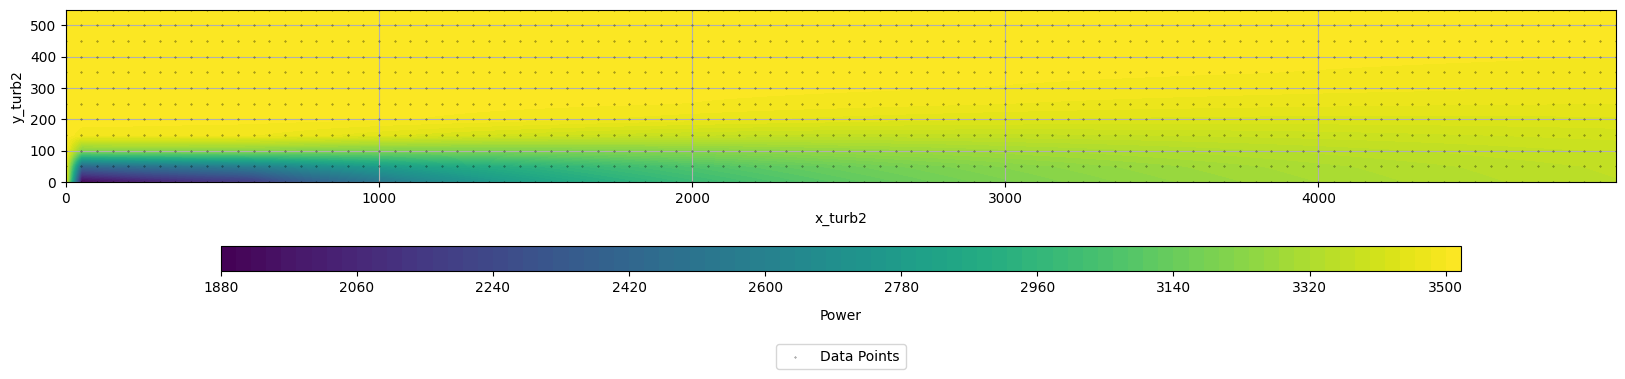

In [14]:
plot_two_turbine_results(data, zfeature = "farm_power",dpoint_size=0.1)

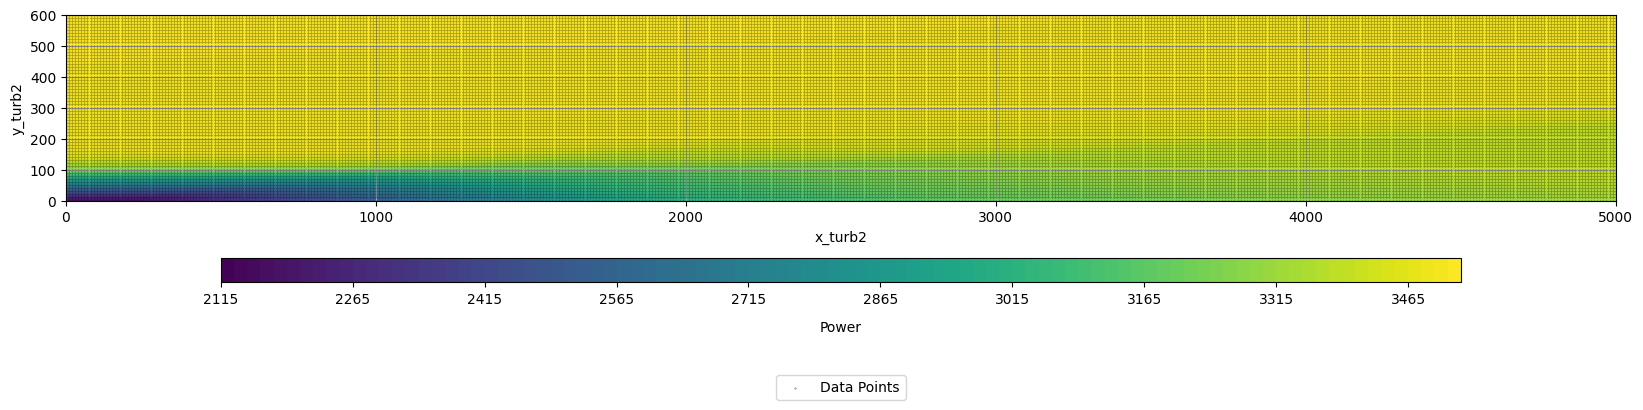

In [15]:
plot_two_turbine_results(generated_data, zfeature = "pred",dpoint_size=0.1)

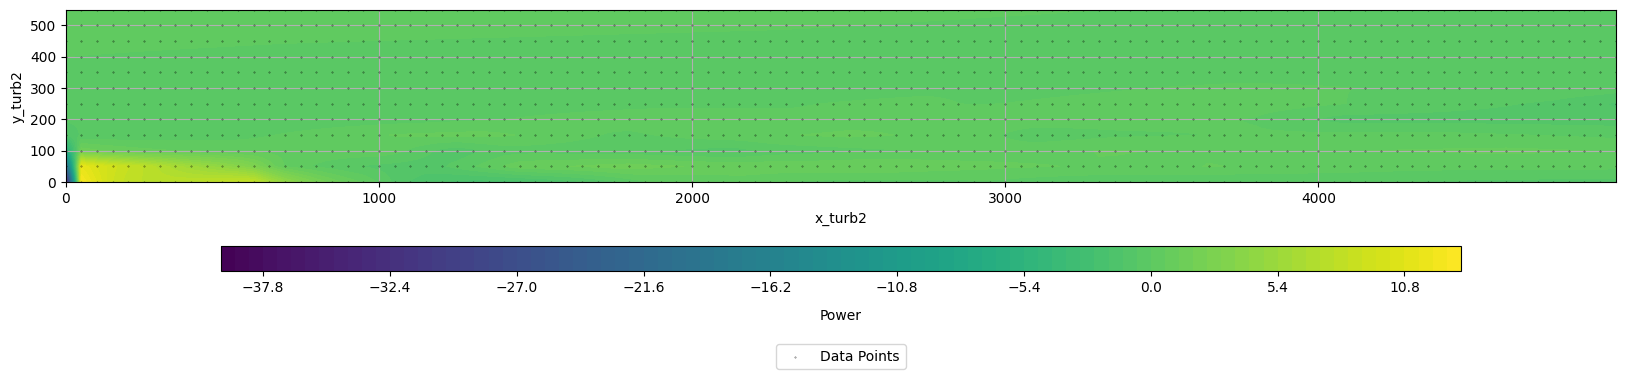

In [16]:
plot_two_turbine_results(data, zfeature = "error_percent",dpoint_size=0.1)